In [4]:
import numpy as np
import pandas as pd
import time
import scipy
import itertools
import seaborn as sns
import os
import itertools

import importlib.util
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la

from sklearn.datasets import load_svmlight_file
from helpers import get_solution, read_logs, run_local_sgd
from np_functions import logreg_loss as single_point_loss

sns.set(style="whitegrid", context="talk", font_scale=1.2)
%load_ext autoreload
%autoreload 2

AttributeError: module 'pandas' has no attribute 'plotting'

### Specify everything in config.py and then go below

##### If you are running experiments on a laptop, it's better to use small number of workers

In [ ]:
!python generate_data.py

In [ ]:
import config
from config import datasets_path, scripts_path, dataset, n_workers, big_regularization, use_local_data, scripts_path, logs_path

data_path = '{}/data'.format(scripts_path)
zero_based = {'mushrooms': False}

data = load_svmlight_file('{}/{}'.format(datasets_path, dataset), zero_based=zero_based.get(dataset, 'auto'))
l1 = 0 # We don't care about prox
X, y = data[0].toarray(), data[1]
if 2 in y:
    y[y == 2] = -1
n, d = X.shape
L = 0.25 * np.max(np.sum(np.square(X), axis=1))
data_info = np.load('{}/data/data_info.npy'.format(scripts_path))
Ls = data_info[4:]
l2 = np.mean(Ls) / n

In [ ]:
def logreg_loss(w, X, y, l2):
    assert l2 >= 0
    assert len(y) == X.shape[0]
    assert len(w) == X.shape[1]
    l = np.log(1 + np.exp(-X.dot(w) * y))
    m = y.shape[0]
    return np.sum(l) / m + l2/2 * la.norm(w) ** 2

def r(x, l1):
    return l1 * la.norm(x, ord = 1)

def F(w, X, y, l2, l1=0):
    assert ((y.shape[0] == X.shape[0]) & (w.shape[0] == X.shape[1]))
    assert ((l2 >= 0) & (l1 >= 0))
    return logreg_loss(w, X, y, l2) + r(w, l1)

In [ ]:
w_star, ws_star = get_solution(X, y, L, l2=l2, data_path=data_path, dataset=dataset, 
                               big_regularization=big_regularization, recompute=True)
losses_svrg = [F(w, X, y, l2=l2, l1=l1) for w in ws_star]
plt.plot(losses_svrg - np.min(losses_svrg))
plt.yscale('log')
f_min = F(w_star, X, y, l2=l2, l1=l1)
f_min

## Run local GD with 1 / (L * H)

In [ ]:
for H in [1, 10, 100]:
    lr0s = [1 / H] # lr0=a translates to a/L
    lr_decays = [0]
    batches = [0]
    local_steps = [H]
    it_max = 0
    t_max = H
    run_local_sgd(n_workers, scripts_path, it_max, t_max, batches, lr0s, lr_decays, local_steps)

In [ ]:
plt.figure(figsize=(9, 6))
for H in [1, 10, 100]:
    lr0s = [1 / H]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
                label = '1 local step' if H == 1 else '{} local steps'.format(local)
        plt.plot(its, loss - f_min, label=label)
plt.yscale('log')
plt.xlabel('Communication rounds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(9, 6))
for H in [1, 10, 100]:
    lr0s = [1 / H]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = '1 local step' if H == 1 else '{} local steps'.format(local)
        plt.plot(ts, loss - f_min, label=label)
plt.yscale('log')
plt.xlabel('Time, seconds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()

## Run local GD with step 1 / L

In [ ]:
from np_functions import logreg_grad
step = len(y) // n_workers
np.mean([la.norm(logreg_grad(w_star, X[step * i: step * (i+1)], y[step * i: step * (i+1)], l2)) ** 2 for i in range(n_workers)])

In [ ]:
Hs = [1, 2, 4, 8, 16, 32]
for H in Hs:
    lr0s = [1] # lr0=a translates to a/L
    lr_decays = [0]
    batches = [0]
    local_steps = [H]
    it_max = 25000
    t_max = 0
    run_local_sgd(n_workers, scripts_path, it_max, t_max, batches, lr0s, lr_decays, local_steps)

In [ ]:
plt.figure(figsize=(9, 6))
last_loss = []
markers = [',', 'o', '*', 'x', 'd', 'D']
mv = 10
for H, marker in zip(Hs, markers):
    lr0s = [1]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = '1 local step' if H == 1 else '{} local steps'.format(local)
        plt.plot(its, loss - f_min, label=label, marker=marker, markevery=mv * 2)
    if H != 1:
        last_loss.append(loss[-1] - f_min)
plt.yscale('log')
plt.xlabel('Communication rounds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/local_sgd/gd_a5a_dif_H_same_lr_rounds.pdf', dpi=300)

In [ ]:
plt.figure(figsize=(9, 6))
for H, marker in zip(Hs, markers):
    lr0s = [1]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = '1 local step' if H == 1 else '{} local steps'.format(local)
        idx = ts < 115
        plt.plot(ts[idx], loss[idx] - f_min, label=label, marker=marker, markevery=4 * max(1, (2 * mv) // H))
plt.yscale('log')
plt.xlabel('Time, seconds')
plt.xlim(-5, 120)
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/local_sgd/gd_a5a_dif_H_same_lr_time.pdf', dpi=300)

In [ ]:
plt.figure(figsize=(9, 6))
our_comm_time_to_all_time = 0.307 # from the output file
our_ratio = our_comm_time_to_all_time / (1 - our_comm_time_to_all_time)
ratios = np.linspace(0, our_ratio * 3, 100)
epsilon = 1e-4
for H, marker in zip(Hs, markers):
    lr0s = [1]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = '1 local step' if H == 1 else '{} local steps'.format(local)
#         plt.plot(ts, loss - f_min, label=label, marker=marker, markevery=5 * max(1, mv // H))
        t_epsilon = ts[np.argmax(loss - f_min < epsilon) + 1] # t_comm + H * t_gr
        time_per_gradient = t_epsilon / (H + our_ratio) # t_gr = (t_comm + H * t_gr) / (t_comm/t_gr + H)
        ts_epsilon = [time_per_gradient * (H + r) for r in ratios]
        plt.plot(ratios, ts_epsilon, label=label, marker=marker, markevery=mv)
# plt.yscale('log')
plt.axvline(x=our_ratio, label='Our system', color='black')
plt.xlabel(r'$T_{communication}/T_{computation}$')
# plt.xlim(-5, 120)
plt.ylabel('Time to accuracy $10^{-4}$')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/local_sgd/gd_a5a_dif_H_dif_ratio.pdf', dpi=300)

## Run local GD with $1 / (L  \sqrt{H}$)

In [50]:
for H in [1, 10, 100]:
    lr0s = [1 / np.sqrt(H)] # lr0=a translates to a/Lw
    lr_decays = [0]
    batches = [0]
    local_steps = [H]
    it_max = 0
    t_max = 300 if H > 1 else 100
    run_local_sgd(n_workers, scripts_path, it_max, t_max, batches, lr0s, lr_decays, local_steps)

###

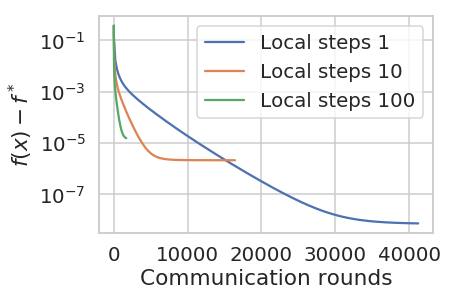

In [51]:
plt.figure(figsize=(9, 6))
for H in [1, 10, 100]:
    lr0s = [1 / np.sqrt(H)]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = 'Gradient descent' if H == 1 else '{} local steps'.format(local)
        plt.plot(its, loss - f_min, label='Local steps {}'.format(local))
plt.yscale('log')
plt.xlabel('Communication rounds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()

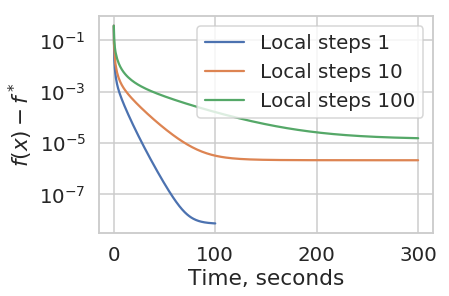

In [52]:
plt.figure(figsize=(9, 6))
for H in [1, 10, 100]:
    lr0s = [1 / np.sqrt(H)]
    local_steps = [H]
    for params in itertools.product(batches, lr0s, lr_decays, local_steps):
        batch, lr0, lr_decay, local = params
        ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
        label = 'Gradient descent' if H == 1 else '{} local steps'.format(local)
        plt.plot(ts, loss - f_min, label='Local steps {}'.format(local))
plt.yscale('log')
plt.xlabel('Time, seconds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()